# Vehicle Routing Problem
## Ant Colony Optimization


In [219]:
import xml.etree.ElementTree as ET
from collections import namedtuple
import math
import functools
import numpy as np
%matplotlib inline

Calculate the fitness of solution. The fitness is equal to the sum of distances traveled in each of the paths.

In [221]:
def vrp_fitness(routes, depot, distance_fn):
    total_distance = 0
    for route in routes:
        if not route:
            continue
        total_distance += distance_fn(depot, route[0])
        for i in range(len(route) - 1):
            total_distance += distance_fn(route[i], route[i + 1])
        total_distance += distance_fn(route[-1], depot)
    return total_distance


Generate a possible solution based on the alpha beta heuristics and pheromones on the edges.
It is easier to imagine rather than we are delivering packages we can do the reverse and be collecting packages from customers. We send out a car. Which is driving around while the place that it wants to visit has small enough package that we can fit in. If this package is too big we go to depot and send out another car. This approach is better than choosing cities while there exists a city that has small enough package that we can fit it in as this can send us driving around cities with small packages that are far away from each other.

In [293]:
def generate_vrp_solution(customers, depot, pheromones, heuristic, capacity, alpha, beta):
    unvisited = customers.copy()
    routes = []

    while unvisited:
        route = []
        load = 0
        current = depot

        while unvisited:
            probs = []
            for c in unvisited:
                i, j = current.name, c['vertex'].name
                tau = pheromones[(i, j)]
                eta = heuristic[(i, j)]
                probs.append((tau ** alpha) * (eta ** beta))

            probs = np.array(probs)
            probs /= probs.sum()

            selected_idx = np.random.choice(len(unvisited), p=probs)
            selected_customer = unvisited[selected_idx]

            if load + selected_customer['demand'] > capacity:
                break

            route.append(selected_customer['vertex'])
            load += selected_customer['demand']
            unvisited.remove(selected_customer)
            current = selected_customer['vertex']

        routes.append(route)

    return routes

We are changing the pheromones on edges throughout the iteration and based on this also the probabilities.

In [254]:
def ant_solver_vrp(customers, depot, capacity, distance_fn, number_of_ants, max_iterations, alpha, beta, Q, rho):
    all_vertices = [depot] + [c['vertex'] for c in customers]
    node_ids = [v.name for v in all_vertices]
    pheromones = {(i, j): 1.0 for i in node_ids for j in node_ids if i != j}
    heuristic = compute_normalized_heuristic(all_vertices, distance_fn)

    best_solution = None
    best_fitness = float("inf")
    fitness_log = []

    for iteration in range(max_iterations):
        solutions = [
            generate_vrp_solution(customers, depot, pheromones, heuristic, capacity, alpha, beta)
            for _ in range(number_of_ants)
        ]
        fitnesses = [vrp_fitness(sol, depot, distance_fn) for sol in solutions]

        for k in pheromones:
            pheromones[k] *= (1 - rho)

        for sol, fit in zip(solutions, fitnesses):
            for route in sol:
                if not route:
                    continue
                prev = depot
                for node in route:
                    pheromones[(prev.name, node.name)] += Q / fit
                    prev = node
                pheromones[(prev.name, depot.name)] += Q / fit

        pheromones = normalize_pheromones(pheromones)

        min_idx = np.argmin(fitnesses)
        if fitnesses[min_idx] < best_fitness:
            best_fitness = fitnesses[min_idx]
            best_solution = solutions[min_idx]

        fitness_log.append(fitnesses[min_idx])
        print(f"Iteration {iteration}: Distance = {fitnesses[min_idx]:.2f}")

    return best_solution, fitness_log,pheromones

We normalize the heuristics such that the length of average edge is 1.

In [290]:
def compute_normalized_heuristic(vertices, distance_fn):
    heuristic = {}
    values = []
    for i in vertices:
        for j in vertices:
            if i.name == j.name:
                continue
            d = distance_fn(i, j)
            inv_d = 1 / d
            heuristic[(i.name, j.name)] = inv_d
            values.append(inv_d)
    avg = sum(values) / len(values)
    for k in heuristic:
        heuristic[k] /= avg
    return heuristic

We normalize the pheromones such that on average edge the pheromone value is 1.

In [291]:
@functools.lru_cache(maxsize=None)
def distance_function(v1, v2):
    return math.hypot(v1.x - v2.x, v1.y - v2.y)

def normalize_pheromones(pheromones):
    total = sum(pheromones.values())
    if total == 0:
        return pheromones
    factor = len(pheromones) / total
    for k in pheromones:
        pheromones[k] *= factor
    return pheromones


plot the best solution

In [292]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc

def plot_pheromones_and_routes(pheromones, solution, vertices, depot):
    vertex_dict = {v.name: v for v in vertices}
    vertex_dict[depot.name] = depot

    lines = []
    strengths = []
    for (i_name, j_name), value in pheromones.items():
        v1 = vertex_dict[i_name]
        v2 = vertex_dict[j_name]
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        strengths.append(value)

    strengths = np.array(strengths)
    if strengths.max() > 0:
        strengths = 0.5 + 4.5 * (strengths / strengths.max())

    lc = mc.LineCollection(lines, linewidths=strengths, colors='blue', alpha=0.3)

    solution_lines = []
    for route in solution:
        if not route:
            continue
        prev = depot
        for node in route:
            solution_lines.append([(prev.x, prev.y), (node.x, node.y)])
            prev = node
        solution_lines.append([(prev.x, prev.y), (depot.x, depot.y)])

    solutions_lc = mc.LineCollection(solution_lines, colors="red", linewidths=2)

    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.add_collection(lc)
    ax.add_collection(solutions_lc)

    xs = [v.x for v in vertices] + [depot.x]
    ys = [v.y for v in vertices] + [depot.y]
    plt.scatter(xs, ys, color='black', s=20, label='Nodes')
    plt.scatter([depot.x], [depot.y], color='green', s=100, marker='*', label='Depot')

    ax.autoscale()
    plt.title("ACO VRP: Pheromone Trails (blue) and Best Routes (red)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.show()


Parses the XML file and returns customer and vehicle data.

In [226]:
def load_data(input_file):
    tree = ET.parse(input_file)
    root = tree.getroot()

    Vertex = namedtuple("Vertex", ["name", "x", "y"])

    vertices = []
    start_node = None

    for node in root.findall('.//node'):
        node_id = int(node.attrib['id'])
        node_type = int(node.attrib['type'])
        cx = float(node.find('cx').text)
        cy = float(node.find('cy').text)
        vertex = Vertex(name=node_id, x=cx, y=cy)

        if node_type == 0:
            start_node = vertex
        else:
            vertices.append(vertex)

    requests = []
    for req in root.findall('.//request'):
        req_id = int(req.attrib['id'])
        node_id = int(req.attrib['node'])
        quantity = float(req.find('quantity').text)
        requests.append({'id': req_id, 'node': node_id, 'quantity': quantity})

    vehicle = root.find('./fleet/vehicle_profile')
    capacity = float(vehicle.find('capacity').text)

    node_map = {v.name: v for v in vertices}
    node_map[start_node.name] = start_node

    customers = []
    for req in requests:
        node_id = req['node']
        quantity = req['quantity']
        customers.append({'id': node_id, 'vertex': node_map[node_id], 'demand': quantity})

    return customers,start_node,capacity

In all instances I found the best parameters for beta and alpha were alpha=1 and beta=3 as in the other cases it often found a local maximum. Also, the rho was best around 0.2 - 0.4 as lower rho meant I was not loosing any of the pheromone and higher rho meant that I lost almost all of it and relying on the heuristics. As the pheromones are being normalized lower Q was also better.
The best results I have found were
802 for data 32.
274 for data 72.
2231 for data 442.


### Instance for data 32

Iteration 0: Distance = 995.11
Iteration 1: Distance = 1070.93
Iteration 2: Distance = 1044.15
Iteration 3: Distance = 1081.91
Iteration 4: Distance = 1048.48
Iteration 5: Distance = 1041.82
Iteration 6: Distance = 1052.15
Iteration 7: Distance = 1059.15
Iteration 8: Distance = 1044.89
Iteration 9: Distance = 1047.89
Iteration 10: Distance = 1024.42
Iteration 11: Distance = 951.10
Iteration 12: Distance = 1086.72
Iteration 13: Distance = 1082.15
Iteration 14: Distance = 987.24
Iteration 15: Distance = 1027.45
Iteration 16: Distance = 1066.20
Iteration 17: Distance = 1006.30
Iteration 18: Distance = 976.42
Iteration 19: Distance = 1071.31
Iteration 20: Distance = 1054.50
Iteration 21: Distance = 1027.61
Iteration 22: Distance = 1031.41
Iteration 23: Distance = 1066.53
Iteration 24: Distance = 1031.04
Iteration 25: Distance = 1061.62
Iteration 26: Distance = 982.65
Iteration 27: Distance = 1117.89
Iteration 28: Distance = 967.91
Iteration 29: Distance = 1046.80
Iteration 30: Distance = 9

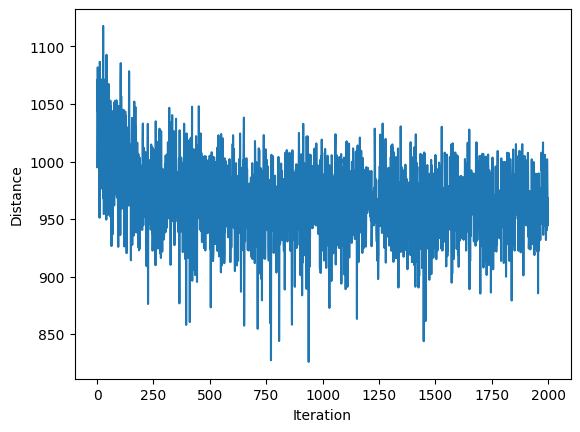

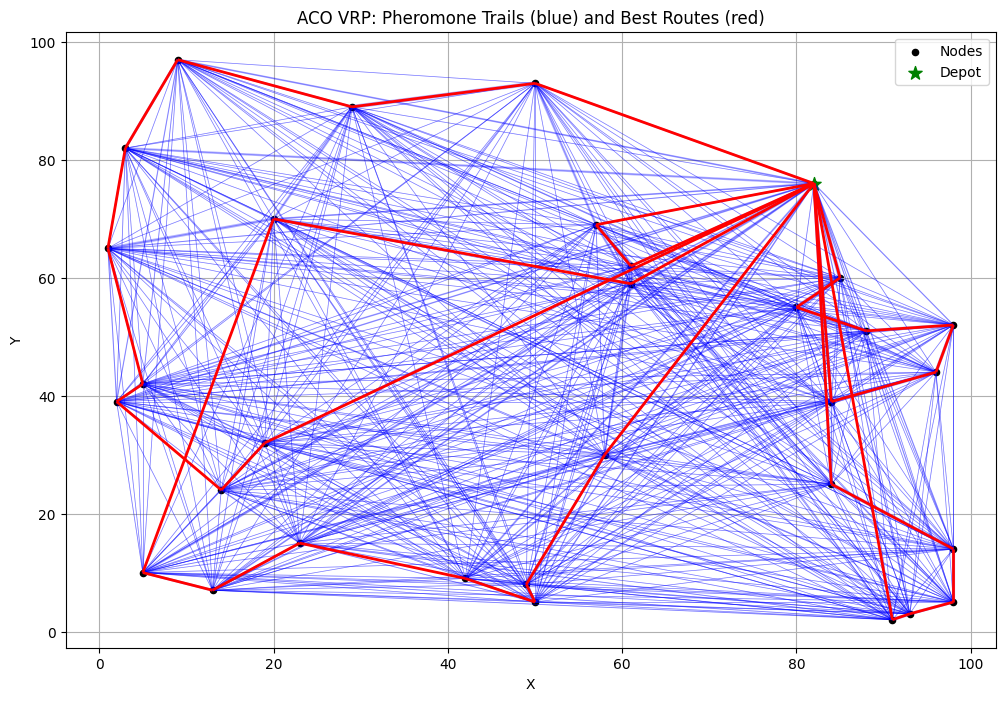

In [308]:
customers,start_node,capacity = load_data("data_32.xml")
solution, log,pheromones = ant_solver_vrp(customers, start_node, capacity, distance_function,number_of_ants=10,max_iterations=2000,alpha=1,beta=3,Q=7,rho=0.2)
print("Best solution:", min(log))
for idx, route in enumerate(solution):
    print(f"Route {idx + 1}: {[v.name for v in route]}")
plt.plot(log)
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.show()
plot_pheromones_and_routes(pheromones, solution, [c['vertex'] for c in customers], start_node)

### Instance for data 72

Iteration 0: Distance = 388.57
Iteration 1: Distance = 347.56
Iteration 2: Distance = 389.17
Iteration 3: Distance = 349.18
Iteration 4: Distance = 356.37
Iteration 5: Distance = 385.88
Iteration 6: Distance = 370.89
Iteration 7: Distance = 332.12
Iteration 8: Distance = 377.13
Iteration 9: Distance = 341.07
Iteration 10: Distance = 390.58
Iteration 11: Distance = 353.40
Iteration 12: Distance = 379.61
Iteration 13: Distance = 352.42
Iteration 14: Distance = 354.70
Iteration 15: Distance = 333.24
Iteration 16: Distance = 369.46
Iteration 17: Distance = 331.84
Iteration 18: Distance = 387.48
Iteration 19: Distance = 367.45
Iteration 20: Distance = 344.00
Iteration 21: Distance = 352.38
Iteration 22: Distance = 390.92
Iteration 23: Distance = 326.78
Iteration 24: Distance = 362.84
Iteration 25: Distance = 361.91
Iteration 26: Distance = 336.08
Iteration 27: Distance = 366.16
Iteration 28: Distance = 332.25
Iteration 29: Distance = 358.00
Iteration 30: Distance = 358.72
Iteration 31: Dist

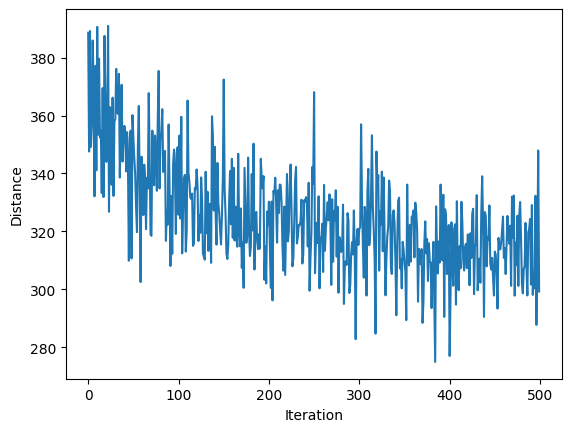

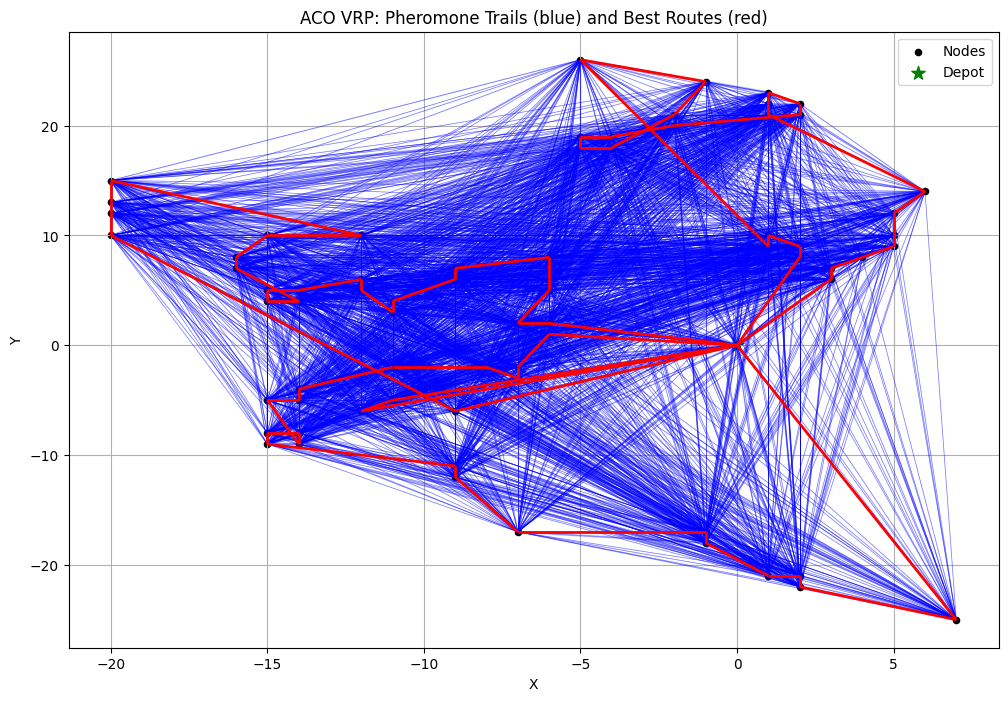

In [309]:
customers,start_node,capacity = load_data("data_72.xml")
solution, log,pheromones = ant_solver_vrp(customers, start_node, capacity, distance_function,number_of_ants=10,max_iterations=500,alpha=1,beta=3,Q=7,rho=0.30)
print("Best solution:", min(log))
for idx, route in enumerate(solution):
    print(f"Route {idx + 1}: {[v.name for v in route]}")
plt.plot(log)
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.show()
plot_pheromones_and_routes(pheromones, solution, [c['vertex'] for c in customers], start_node)

### Instance for data 422

Iteration 0: Distance = 2973.10
Iteration 1: Distance = 3062.25
Iteration 2: Distance = 3015.41
Iteration 3: Distance = 2997.95
Iteration 4: Distance = 3019.58
Iteration 5: Distance = 2982.56
Iteration 6: Distance = 3000.65
Iteration 7: Distance = 2940.77
Iteration 8: Distance = 2904.22
Iteration 9: Distance = 2966.02
Iteration 10: Distance = 3028.17
Iteration 11: Distance = 2947.80
Iteration 12: Distance = 2888.62
Iteration 13: Distance = 2980.15
Iteration 14: Distance = 2942.60
Iteration 15: Distance = 2922.59
Iteration 16: Distance = 2875.51
Iteration 17: Distance = 2989.73
Iteration 18: Distance = 2962.92
Iteration 19: Distance = 2960.80
Iteration 20: Distance = 2887.98
Iteration 21: Distance = 2877.10
Iteration 22: Distance = 2911.89
Iteration 23: Distance = 2887.31
Iteration 24: Distance = 2852.70
Iteration 25: Distance = 2897.17
Iteration 26: Distance = 2899.26
Iteration 27: Distance = 2844.48
Iteration 28: Distance = 2882.82
Iteration 29: Distance = 2777.17
Iteration 30: Distan

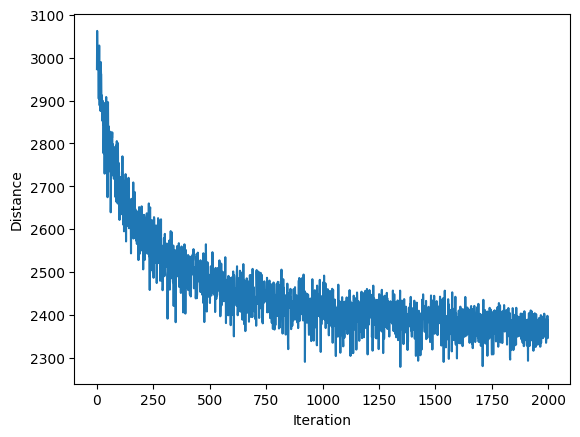

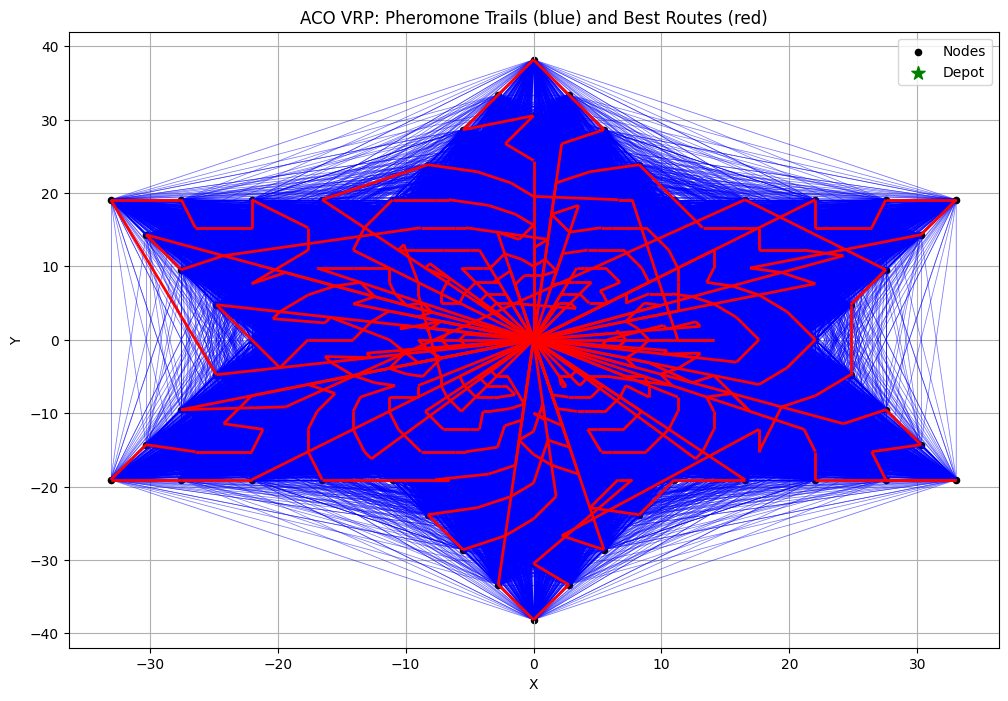

In [311]:
customers,start_node,capacity = load_data("data_422.xml")
solution, log,pheromones = ant_solver_vrp(customers, start_node, capacity, distance_function,number_of_ants=20,max_iterations=2000,alpha=1,beta=3,Q=15,rho=0.35)
print("Best solution:", min(log))
for idx, route in enumerate(solution):
    print(f"Route {idx + 1}: {[v.name for v in route]}")
plt.plot(log)
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.show()
plot_pheromones_and_routes(pheromones, solution, [c['vertex'] for c in customers], start_node)